<a href="https://github.com/Deffro/Data-Science-Portfolio/tree/master"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Fn3wll0VC_IzqbPBVGY0FX8WJrZs60Y3?usp=sharing)

# **Introduction**

This project focuses on the **sentiment analysis of product reviews** from the [Flipkart Customer Review dataset](https://www.kaggle.com/datasets/kabirnagpal/flipkart-customer-review-and-rating?resource=download). Sentiment analysis is a crucial task in Natural Language Processing (NLP) that aims to classify text into positive, negative, or neutral sentiments, enabling businesses to gain insights from customer feedback.

Our objective is to explore and compare multiple methods for binary sentiment classification, evaluating their performance and computational efficiency. The methods range from simple traditional approaches to advanced techniques leveraging embeddings and generative models.

---

## **Goals**

1. **Dataset Analysis and Preprocessing**:
   - Explore the Flipkart Customer Review dataset and preprocess it to create a binary classification task.
   - Focus on clear sentiment polarities (positive and negative), excluding neutral reviews.

2. **Method Exploration**:
   - Experiment with diverse approaches for text classification, including:
     - Logistic Regression with **TF-IDF**.
     - Logistic Regression with **pretrained embeddings**.
     - **Zero-shot classification** using embeddings and cosine similarity.
     - **Generative language models** (e.g., Flan-T5).
     - **Task-specific sentiment models** fine-tuned for review classification.

3. **Performance Evaluation**:
   - Evaluate models using standard classification metrics such as **precision**, **recall**, **F1-score**, and **accuracy**.
   - Analyze the trade-offs between performance and computational efficiency.

---

## **Why Sentiment Analysis?**

Sentiment analysis enables businesses to:
- Understand customer opinions and preferences.
- Identify trends and issues in product feedback.
- Enhance decision-making for product improvement and customer satisfaction.

By leveraging a wide range of NLP techniques, this project demonstrates how various approaches can be applied to achieve sentiment analysis, with each method tailored to specific use cases and resource constraints.

---

## **Overview of Methods**

1. **Logistic Regression with TF-IDF**:
   - A simple yet effective baseline using term-frequency-based features for classification.

2. **Logistic Regression with Pretrained Embeddings**:
   - Utilize advanced embedding models like `all-MiniLM-L6-v2` to generate semantic representations for training a classifier.

3. **Zero-shot Classification**:
   - Perform classification without labeled data by leveraging cosine similarity between document and label embeddings.

4. **Generative Models**:
   - Explore generative language models like `Flan-T5`, which classify text by generating responses based on a prompt.

5. **Task-Specific Sentiment Models**:
   - Leverage fine-tuned sentiment models like `juliensimon/reviews-sentiment-analysis` for domain-specific performance.

---

# **Results Overview**

The table below summarizes the accuracy achieved by each method explored in this project:

| **Method**                                   | **Labeled Data** | **Accuracy** | **Time Taken**      |
|----------------------------------------------|------------------|--------------|---------------------|
| Logistic Regression using TF-IDF            | Yes              | 0.87         | ~1 second           |
| Logistic Regression with embeddings (all-MiniLM-L6-v2) | Yes              | 0.85         | ~1 minute           |
| Logistic Regression with embeddings (all-mpnet-base-v2) | Yes              | 0.87         | ~7 minutes          |
| Zero-shot classification (all-mpnet-base-v2) | No               | 0.78         | ~5 seconds          |
| Classification using Generative Models (Flan-T5)        | No               | 0.86         | ~30 seconds         |
| Task-Specific Sentiment Model (juliensimon/reviews-sentiment-analysis) | No               | 0.79         | ~4 seconds          |


---


This project highlights the strengths and limitations of each approach, providing a comprehensive guide to applying sentiment analysis techniques to real-world datasets.


## Before We Begin

If you are viewing this notebook on **Google Colab** (or any other cloud platform), please ensure that all necessary dependencies are installed.

Uncomment and run the following code block to install the required packages:

In [1]:
# %%capture
# !pip install datasets transformers sentence-transformers

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# **Flipkart Customer Review Dataset Analysis**

## Dataset Overview





The Flipkart Customer Review dataset consists of two main columns:

- **`review`**: Textual reviews provided by customers about the product.
- **`rating`**: Numeric ratings (stars) given by customers, ranging from 1 to 5.

The `rating` column represents the number of stars a customer assigned to a product. Higher values indicate a more favorable review.

---

### Label Creation

To streamline our analysis, we will create a new column, `label`, based on the `rating`:

- **Positive**: If `rating > 4` (e.g., 5 stars)
- **Negative**: If `rating < 4` (e.g., 1 or 2 stars)
- **Neutral ratings (3 stars)** are excluded from this analysis.

---

This preprocessing step will help us focus on clear sentiment polarities (positive and negative) in the reviews.


In [3]:
data = pd.read_csv('data.csv')
data = data[data["rating"]!=4]
data["label"] = data["rating"].apply(lambda x: 1 if x >= 4 else 0)

In [4]:
data["label"].value_counts()

,count
label,
1,5726
0,1885


### Balancing the Dataset

For the purpose of this example, we will down-sample the **Positive** class to match the size of the **Negative** class.

This ensures that the dataset is balanced and avoids biases in model training due to class imbalance.

It also ensures faster computational times as we have less data.

In [5]:
# Down-sample the positive class and combine with the negative class
data = pd.concat([
    data[data["label"] == 1].sample(n=len(data[data["label"] == 0]), random_state=1),
    data[data["label"] == 0]
])

# Shuffle the resulting dataset
data = data.sample(frac=1, random_state=1).reset_index(drop=True)

In [6]:
data

,review,rating,label
0,Sometimes I can only hear the songs from one s...,5,1
1,There cannot be a better product from such a l...,5,1
2,Not Gud Sound .. Feeling like a average sound ...,1,0
3,Wonderful pro𝐝𝐮𝐜𝐭READ MORE,5,1
4,Nice productREAD MORE,5,1
...,...,...,...
3765,only one month use and one side speaker did no...,1,0
3766,SuperbREAD MORE,5,1
3767,great productREAD MORE,5,1
3768,it's amazing nice product I love it best go fo...,5,1


### Data Split

We split the data in 80% train set and 20% test set.

In [7]:
train = data[:int(0.8*len(data))]
test = data[int(0.8*len(data)):].reset_index(drop=True)

In [8]:
train.shape, test.shape

((3016, 3), (754, 3))

## **Text Classification**

## **1. Logistic Regression using tf-idf**



First of all, before trying anything fancy we will employ a simple Logistic Regression for our binary classification task.

To represent the text data numerically, we will use **TF-IDF (Term Frequency-Inverse Document Frequency)**, a popular feature extraction technique for text data.

TF-IDF measures the importance of a term in a document relative to the entire corpus, providing a weighted representation that enhances the influence of unique and informative words while reducing the weight of common words.

### Why Start with Logistic Regression and TF-IDF?

1. **Simplicity and Interpretability**:
   - Logistic Regression is straightforward, easy to interpret, and provides clear insights into the relationship between features and labels.
   - TF-IDF offers a simple yet powerful way to represent text numerically by emphasizing important terms while reducing the weight of common ones.

2. **Baseline Performance**:
   - This combination helps establish a solid baseline to evaluate the effectiveness of future improvements, such as embeddings or LLMs.

3. **Efficiency**:
   - Both Logistic Regression and TF-IDF are computationally lightweight, making them ideal for smaller datasets and quick experimentation.

4. **Proven Effectiveness**:
   - Logistic Regression paired with TF-IDF has consistently performed well in text classification tasks, especially for datasets with linearly separable features.

5. **Iterative Workflow**:
   - Starting simple allows us to debug and refine the pipeline efficiently before introducing complexity like embeddings or LLMs.


In [9]:
# Features and labels
X_train = train['review']
y_train = train['label']
X_test = test['review']
y_test = test['label']

# Convert text data into numerical features using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Logistic Regression Model
model = LogisticRegression(random_state=1)
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       360
           1       0.87      0.89      0.88       394

    accuracy                           0.87       754
   macro avg       0.87      0.87      0.87       754
weighted avg       0.87      0.87      0.87       754



## **2. Logistic Regression with embeddings as features**



In this experiment, we will leverage **pretrained embedding models** for feature extraction and use these embeddings to train a lightweight classifier for binary classification.

This two-step approach allows us to utilize the power of advanced embedding models without the need for fine-tuning, making it computationally efficient and accessible.

#### Steps Overview:

1. **Feature Extraction**:
   - Use a pretrained embedding model (e.g., `sentence-transformers/all-MiniLM-L6-v2`) to convert textual input into numerical embeddings.
   - The embedding model remains frozen, ensuring minimal computational cost during training.

2. **Train a Classifier**:
   - Utilize the generated embeddings as input features.
   - Train a logistic regression model on these features and labels to perform classification.

3. **Evaluation**:
   - Test the trained classifier on unseen data.
   - Evaluate the performance using metrics like precision, recall, F1-score, and accuracy.

#### Benefits of This Approach:
- **Computational Efficiency**: Embedding generation can be GPU-accelerated or outsourced to APIs, while the classifier is trainable on a CPU.
- **Simplicity**: Separating feature extraction and classification keeps the pipeline straightforward and modular.
- **Versatility**: The classifier can be easily replaced with other algorithms for experimentation.

#### Available pretrained embedding models from `sentence-transformers`:

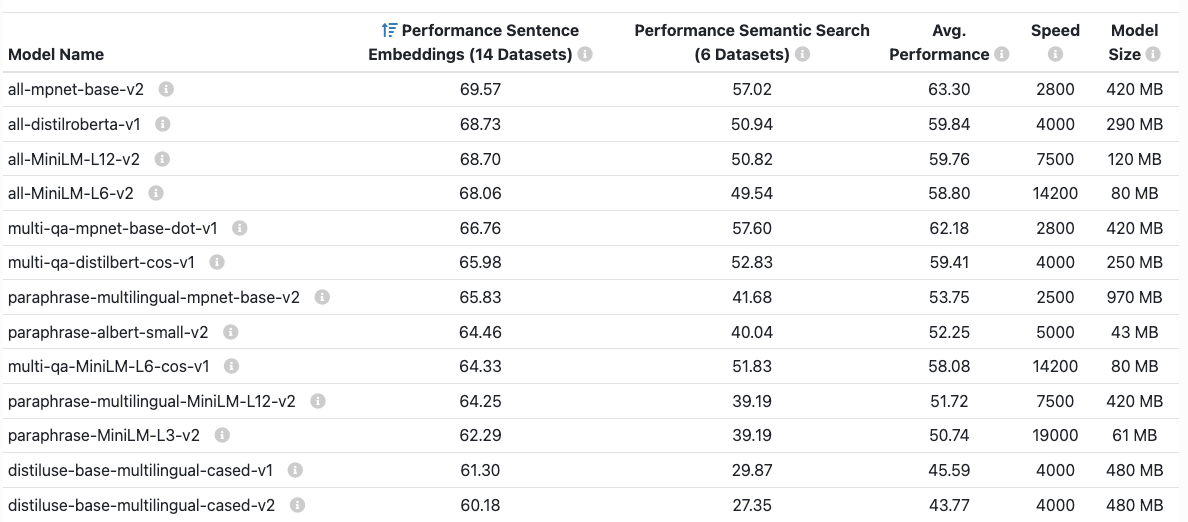

**Why Use all-MiniLM-L6-v2?**
The sentence-transformers/all-MiniLM-L6-v2 model is a highly efficient and versatile embedding model that balances performance and computational requirements, making it a great choice for many text processing tasks. Here's why it is worth considering:

1. **Lightweight Architecture**:
MiniLM (Mini Language Model) is a distilled version of transformer-based models, significantly reducing its size while retaining good performance.
With only 6 layers, it is smaller and faster compared to larger models like all-mpnet-base-v2.

2. **High Efficiency**:
Embedding generation with all-MiniLM-L6-v2 is highly efficient, even on CPUs.
It processes text faster, making it suitable for tasks requiring real-time or large-scale embedding computation.

3. **Competitive Performance**:
Despite being lightweight, it provides high-quality sentence embeddings that are competitive for many NLP tasks like classification, clustering, and semantic search.
The model achieves a good balance between accuracy and speed, with slight trade-offs in performance compared to larger models.

4. **Compact Embeddings**:
The embeddings generated by all-MiniLM-L6-v2 have 384 dimensions, which are more compact than the 768 dimensions of models like all-mpnet-base-v2.
These smaller embeddings reduce memory requirements and improve the speed of downstream tasks like training a classifier.

5. **General Purpose**:
Pretrained on a broad range of datasets, this model captures general-purpose semantic information and works well across diverse domains without fine-tuning.

6. **Scalability**:
Its efficiency and smaller embeddings make it ideal for:
Large datasets.
Applications where computational resources are limited.
Scenarios requiring embeddings to be stored or transferred over networks.


We will first use `all-mpnet-base-v2` to compare its performance and speed with `all-MiniLM-L6-v2`.

In [10]:
from sentence_transformers import SentenceTransformer

# Load model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Convert text to embeddings
train_embeddings = model.encode(train['review'], show_progress_bar=True)
test_embeddings = model.encode(test['review'], show_progress_bar=True)

# Logistic Regression Model
model = LogisticRegression(random_state=1)
model.fit(train_embeddings, y_train)

# Predictions
y_pred = model.predict(test_embeddings)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/95 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       360
           1       0.86      0.87      0.86       394

    accuracy                           0.86       754
   macro avg       0.86      0.86      0.86       754
weighted avg       0.86      0.86      0.86       754



We got and accuracy of 0.87 in about 7 minutes.

Now we will use `all-MiniLM-L6-v2`.

In [11]:
# Load model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Convert text to embeddings
train_embeddings = model.encode(train['review'], show_progress_bar=True)
test_embeddings = model.encode(test['review'], show_progress_bar=True)

# Logistic Regression Model
model = LogisticRegression(random_state=1)
model.fit(train_embeddings, y_train)

# Predictions
y_pred = model.predict(test_embeddings)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/95 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       360
           1       0.86      0.88      0.87       394

    accuracy                           0.86       754
   macro avg       0.86      0.86      0.86       754
weighted avg       0.86      0.86      0.86       754



We got and F1 score of 0.85 in about 1 minute. Much faster without losing a lot of performance.

## **3. Zero-shot classification with embeddings**



In this experiment, we will explore **zero-shot classification**, a technique that allows us to perform classification tasks without any labeled training data.

This approach leverages embeddings and cosine similarity to match input text with predefined label descriptions, enabling classification without the need for resource-intensive labeling efforts.

#### Key Steps:

1. **Defining Labels**:
   - Create descriptions for the labels, such as:
     - "A negative review"
     - "A positive review"
   - These descriptions act as our "pseudo-labels" and are embedded using a pretrained embedding model.

2. **Embedding Documents and Labels**:
   - Use a pretrained model (e.g., `sentence-transformers`) to generate embeddings for both:
     - Input documents (e.g., test data).
     - Label descriptions.

3. **Cosine Similarity**:
   - Calculate the similarity between document embeddings and label embeddings using **cosine similarity**.
   - Assign the label with the highest similarity score to each document.

4. **Evaluation**:
   - Evaluate the predicted labels against the ground truth labels to assess the performance of this zero-shot approach.

#### Advantages of Zero-Shot Classification:
- **No Labeled Data Required**:
  - Eliminates the need for costly and time-consuming manual labeling.
- **Flexible Label Descriptions**:
  - Label descriptions can be tailored to the task or domain, improving embedding relevance.
- **Versatility of Embeddings**:
  - Demonstrates the power of embeddings for a wide range of language tasks beyond supervised classification.

In [12]:
# Step 1: Create embeddings for the label and test data

# Load model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

label_descriptions = ["A negative review", "A positive review"]
label_embeddings = model.encode(label_descriptions)

test_embeddings = model.encode(test['review'], show_progress_bar=True)

# Step 2: Calculate cosine similarity between document and label embeddings
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(test_embeddings, label_embeddings)

# Assign the label with the highest similarity score to each document
y_pred = np.argmax(similarity_matrix, axis=1)

# Step 3: Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.69      0.75       360
           1       0.75      0.86      0.80       394

    accuracy                           0.78       754
   macro avg       0.78      0.77      0.77       754
weighted avg       0.78      0.78      0.78       754



We got an impressive 0.78 accuracy without even having training data!

We used `all-mpnet-base-v2` as `all-MiniLM-L6-v2` gave an accuracy of only 0.66 having a hard time with the negative reviews.

## **4. Classification using Generative Models**

In this experiment, we will explore how **generative language models** can be used for text classification. Unlike traditional classification models that predict numerical values, generative models such as **Flan-T5** generate textual responses, which we map to numerical values for evaluation.

---

#### Key Steps:

1. **Model Selection**:
   - Use the **Flan-T5 model**, a sequence-to-sequence (encoder-decoder) generative model, loaded through the `text2text-generation` task.
   - Begin with the smallest model, `flan-t5-small`, for faster experimentation, and scale to larger versions (e.g., `base`, `large`, `xl`, `xxl`) as needed.

2. **Prompt Engineering**:
   - Guide the model with a **prompt** to contextualize the task, such as:
     ```
     "Is the following review positive or negative?"
     ```
   - Each input document is prefixed with this prompt to ensure the model understands the classification task.

3. **Data Preparation**:
   - Update the dataset to include the prefixed text:
     - Map the prompt and text into a new feature, e.g., `"t5"`.
     - This prepares the dataset for the generative classification pipeline.

4. **Inference**:
   - Run the Flan-T5 model on the test dataset using a pipeline.
   - Collect the generated outputs (e.g., `"positive"` or `"negative"`) and convert them to numerical labels (e.g., 1 for positive, 0 for negative).

5. **Evaluation**:
   - Evaluate the model’s performance using standard metrics like F1-score, precision, and recall.
   - Map the textual output to numerical values for comparison with the ground truth.

---

#### Why Use Flan-T5?

- **Instruction-Tuned Generative Power**:
  - Fine-tuned on over a thousand tasks, the Flan-T5 family of models excels at following instructions and generating accurate, task-specific outputs.
  
- **Flexibility**:
  - The model is not constrained to predefined classes and can adapt to varied tasks through prompt engineering.

- **Pretrained Versatility**:
  - The generative nature allows it to handle tasks it was not explicitly trained for, making it ideal for scenarios with minimal task-specific data.

In [13]:
from datasets import Dataset
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset

# Add a prompt column
prompt = "Is the following review positive or negative? "
test['t5'] = prompt + test['review']

# Convert pandas DataFrame to datasets.Dataset for compatibility with Hugging Face pipeline
dataset = Dataset.from_pandas(test)

In [14]:
dataset

Dataset({
    features: ['review', 'rating', 'label', 't5'],
    num_rows: 754
})

We will use the [pipeline](https://huggingface.co/docs/transformers/v4.47.1/en/main_classes/pipelines#transformers.pipeline) abstraction of Hugging Face.

**Parameters:**

- **task** (str) — The task defining which pipeline will be returned. Some accepted tasks are: `text2text-generation`, `text-classification`, and `text-generation`.
- **model** (str or PreTrainedModel or TFPreTrainedModel, optional) — The model that will be used by the pipeline to make predictions.

The task text2text-generation can be found [here](https://huggingface.co/docs/transformers/v4.47.1/en/main_classes/pipelines#transformers.Text2TextGenerationPipeline) and the models that can be used for this tasks can be found [here](https://huggingface.co/models?pipeline_tag=text2text-generation&sort=trending).



Let's use the `google/flan-t5-small` model.

In [15]:
# Load model
pipe = pipeline(
    task="text2text-generation",
    model="google/flan-t5-small",
    device=0  # Set to -1 for CPU, 0 for GPU
)

Device set to use cuda:0


Let's see the output format for the first review.

The `KeyDataset` returns the content of the particular column defined as `key`.

In [16]:
for output in pipe(KeyDataset(dataset, key="review")):
    print(output)
    break

[{'generated_text': 'superREAD MORE'}]


In [17]:
y_pred = []

# Run inference on the test set
for output in tqdm(pipe(KeyDataset(dataset, key="t5"))):
    generated_text = output[0]["generated_text"]
    # Map textual output to numerical labels
    y_pred.append(0 if generated_text == "negative" else 1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

100%|██████████| 754/754 [00:31<00:00, 23.61it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       360
           1       0.81      0.95      0.88       394

    accuracy                           0.86       754
   macro avg       0.87      0.86      0.86       754
weighted avg       0.87      0.86      0.86       754



## **5. Sentiment Analysis Using a Task-Specific Model**




In this experiment, we will use a **task-specific representation model** for sentiment classification.

Specifically, we will leverage the pretrained **`juliensimon/reviews-sentiment-analysis`** model, which is fine-tuned for sentiment analysis on product reviews, to classify product reviews as positive or negative.

---

#### Key Steps:

1. **Model Loading**:
   - Use the `transformers.pipeline` to load the pretrained model along with its tokenizer.
   - The tokenizer splits the input text into tokens that the model can process.

2. **Inference**:

Pass the test data to the pipeline and retrieve sentiment scores (e.g., negative and positive).

3. **Evaluation**:

Compare the predicted labels (y_pred) against the ground truth labels (y_true).
Use the classification report to evaluate precision, recall, F1-score, and accuracy.

In [18]:
model_path = "juliensimon/reviews-sentiment-analysis"

# Load model into pipeline
pipe = pipeline(
    model=model_path,
    tokenizer=model_path,
    device=0
)

Device set to use cuda:0


In [19]:
for output in pipe(KeyDataset(dataset, key="review")):
    print(output)
    break

{'label': 'LABEL_0', 'score': 0.6483076214790344}


In [20]:
# Convert pandas DataFrame to datasets.Dataset for compatibility with Hugging Face
dataset = Dataset.from_pandas(test)

y_pred = []

# Run inference on the test set
for output in tqdm(pipe(KeyDataset(dataset, key="review"))):
    label = output["label"]
    # Map textual output to numerical labels
    y_pred.append(0 if "0" in label else 1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

100%|██████████| 754/754 [00:03<00:00, 189.65it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       360
           1       0.89      0.69      0.78       394

    accuracy                           0.79       754
   macro avg       0.81      0.80      0.79       754
weighted avg       0.81      0.79      0.79       754

